In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
# torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Automatic differentiation in PyTorch

In [3]:
x = np.array([1, 2]).reshape(-1, 1)

x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)

f = x**3

# torch.ones_like(f) 
# Since grad can be implicitly created only for scalar outputs,
# we have to specify grad_outputs to get a vector return.

# create_graph
# If True, graph of the derivative will be constructed, 
# allowing to compute higher order derivative products.

# [0]
# Return Type: Tuple[Tensor, …]
f_x = torch.autograd.grad(outputs=f, inputs=x, grad_outputs=torch.ones_like(f), create_graph=True)[0]

f_xx = torch.autograd.grad(f_x, x, torch.ones_like(f), create_graph=True)[0]

# print(type(f_x))
print('f_x')
print(f_x)

# print(type(f_xx))
print('f_xx')
print(f_xx)

f_x
tensor([[ 3.],
        [12.]], device='cuda:0', grad_fn=<MulBackward0>)
f_xx
tensor([[ 6.],
        [12.]], device='cuda:0', grad_fn=<MulBackward0>)


In [47]:
x = np.array([1, 2]).reshape(-1, 1)
t = np.array([3, 4]).reshape(-1, 1)

x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)
t = torch.tensor(t, dtype=torch.float, requires_grad=True).to(device)

f = x**3 + x*t + t**2

f_x = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
f_t = torch.autograd.grad(f, t, torch.ones_like(f), create_graph=True)[0]

f_xt = torch.autograd.grad(f_x, t, torch.ones_like(f), create_graph=True)[0]
f_tx = torch.autograd.grad(f_t, x, torch.ones_like(f), create_graph=True)[0]

f_xx = torch.autograd.grad(f_x, x, torch.ones_like(f), create_graph=True)[0]
f_tt = torch.autograd.grad(f_t, t, torch.ones_like(f), create_graph=True)[0]

print('(x, t)')
print(torch.hstack([x, t]))

# print(type(f_x))
print('f_x')
print(f_x)

# print(type(f_t))
print('f_t')
print(f_t)

# print(type(f_xt))
print('f_xt')
print(f_xt)

# print(type(f_tx))
print('f_tx')
print(f_tx)

# print(type(f_xx))
print('f_xx')
print(f_xx)

# print(type(f_tt))
print('f_tt')
print(f_tt)

(x, t)
tensor([[1., 3.],
        [2., 4.]], device='cuda:0', grad_fn=<CatBackward0>)
f_x
tensor([[ 6.],
        [16.]], device='cuda:0', grad_fn=<AddBackward0>)
f_t
tensor([[ 7.],
        [10.]], device='cuda:0', grad_fn=<AddBackward0>)
f_xt
tensor([[1.],
        [1.]], device='cuda:0')
f_tx
tensor([[1.],
        [1.]], device='cuda:0')
f_xx
tensor([[ 6.],
        [12.]], device='cuda:0', grad_fn=<MulBackward0>)
f_tt
tensor([[2.],
        [2.]], device='cuda:0', grad_fn=<MulBackward0>)


# PINN

In [5]:
class DNN(nn.Module):
    
    def __init__(self):
        super(DNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(32, 1)
        )        
    
    def forward(self, x):
        x = self.layer1(x)
        u = self.layer2(x)
        return u

In [6]:
# Loss function
mseloss = nn.MSELoss(reduction='mean')

# Solution function u as Neural Networks
u_NN = DNN().to(device)

In [8]:
# Boundary Conditions

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)

x_bc = torch.tensor(x_bc, dtype=torch.float).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float).to(device)
u_bc_pred = u_NN(x_bc)

loss_bc = mseloss(u_bc, u_bc_pred)

In [10]:
# Differential Equations

# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)

x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

u = u_NN(x)

u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]

def f(x):
    return torch.cos(x)

loss_de = mseloss(u_x, f(x))

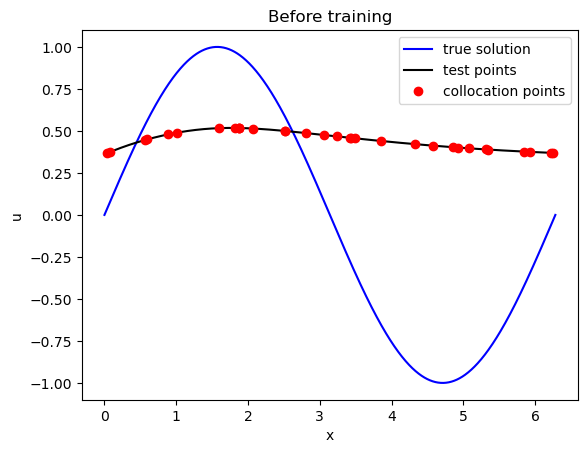

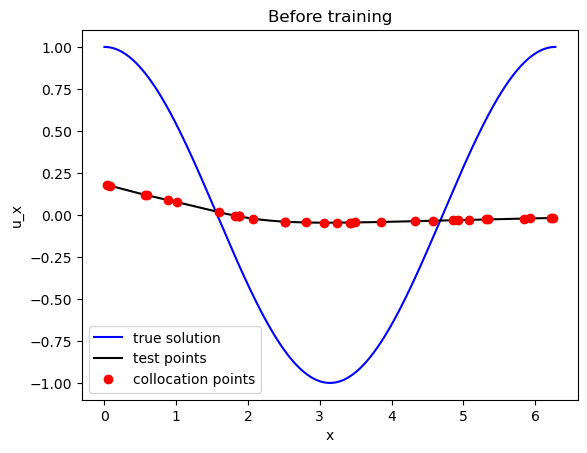

In [11]:
def u_analytic(x):
    return np.sin(x)

def u_x_analytic(x):
    return np.cos(x)

# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Before training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('Before training')
plt.legend()

In [12]:
import time

In [13]:
# Solution function u as Neural Networks
u_NN = DNN().to(device)

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)
x_bc = torch.tensor(x_bc, dtype=torch.float, requires_grad=True).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float, requires_grad=True).to(device)

# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)
x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(u_NN.parameters(), lr=0.001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

# Iterations
iterations = 1000

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = time.time()
for i in range(iterations):
    
    # Boundary Conditions
    u_bc_pred = u_NN(x_bc)
    
    loss_bc = mseloss(u_bc, u_bc_pred)
    
    # Differential Equations
    u = u_NN(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    loss_de = mseloss(u_x, f(x))
    
    loss = lambda_bc*loss_bc + lambda_de*loss_de
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        print(f'Iteration: {i} / Loss {loss}')
t2 = time.time()

print('{} seconds'.format(t2-t1))

Iteration: 0 / Loss 1.0622856616973877
Iteration: 100 / Loss 0.596188485622406
Iteration: 200 / Loss 0.46483319997787476
Iteration: 300 / Loss 0.3528313636779785
Iteration: 400 / Loss 0.2778586745262146
Iteration: 500 / Loss 0.23385967314243317
Iteration: 600 / Loss 0.19334369897842407
Iteration: 700 / Loss 0.14906546473503113
Iteration: 800 / Loss 0.10920888185501099
Iteration: 900 / Loss 0.07491987198591232
Iteration: 999 / Loss 0.04854964092373848
1.8534462451934814 seconds


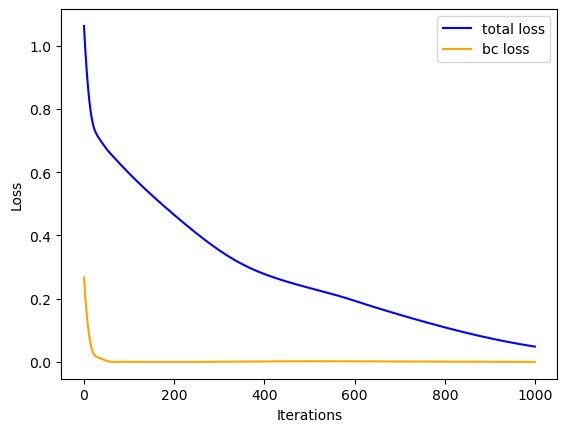

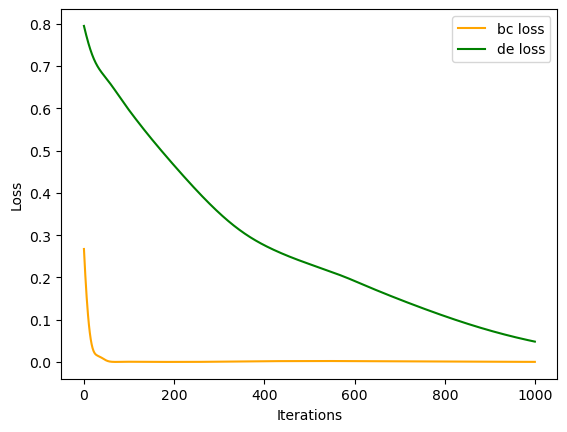

In [14]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

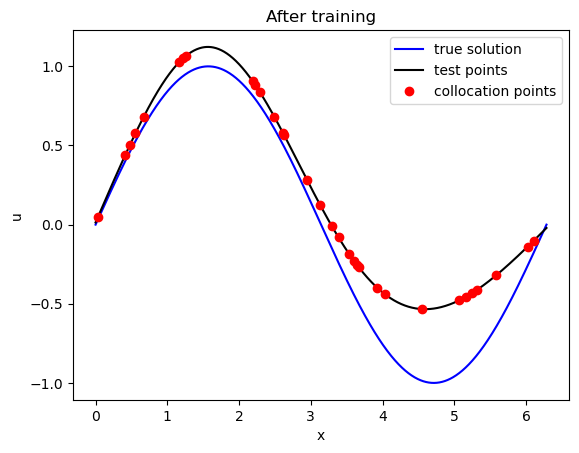

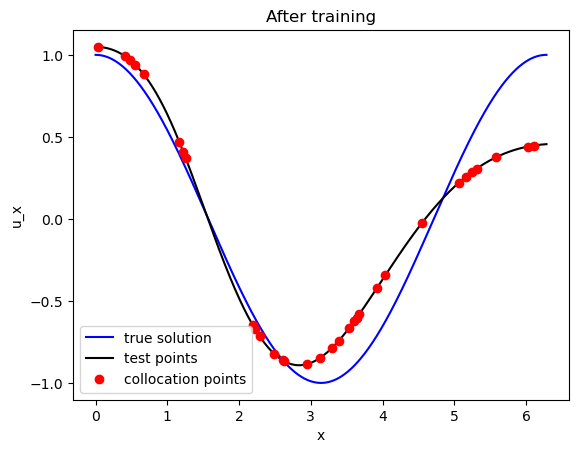

In [15]:
# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('After training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('After training')
plt.legend()

# Mini-batch

In [21]:
from torch.utils.data import TensorDataset, DataLoader

In [27]:
# Solution function u as Neural Networks
u_NN = DNN().to(device)

# points at boundary
x_bc = np.array([0, 2*np.pi]).reshape(-1, 1)
u_bc = np.array([0, 0]).reshape(-1, 1)
x_bc = torch.tensor(x_bc, dtype=torch.float, requires_grad=True).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float, requires_grad=True).to(device)
    
# collocation points
# x = np.linspace(0, 2*np.pi, 32).reshape(-1, 1)
# x = torch.tensor(x, dtype=torch.float, requires_grad=True).to(device)
x = torch.FloatTensor(32, 1).uniform_(0, 2*np.pi)
x.requires_grad = True
x = x.to(device)

dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

# Iterations
iterations = 500

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = time.time()
for i in range(iterations):
    for batch_idx, x_batchs in enumerate(dataloader):
        # Boundary Conditions
        u_bc_pred = u_NN(x_bc)

        loss_bc = mseloss(u_bc, u_bc_pred)

        # Differential Equations
        x_batch = x_batchs[0]
        u = u_NN(x_batch)
        u_x = torch.autograd.grad(u, x_batch, torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        loss_de = mseloss(u_x, f(x_batch))

        loss = lambda_bc*loss_bc + lambda_de*loss_de
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
            

    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        print(f'Iteration: {i} / Loss {loss}')
t2 = time.time()

print('{} seconds'.format(t2-t1))

Iteration: 0 / Loss 0.8063778877258301
Iteration: 100 / Loss 0.12170863151550293
Iteration: 200 / Loss 0.3468443751335144
Iteration: 300 / Loss 0.16537261009216309
Iteration: 400 / Loss 0.11211766302585602
Iteration: 499 / Loss 0.028584925457835197
3.5261940956115723 seconds


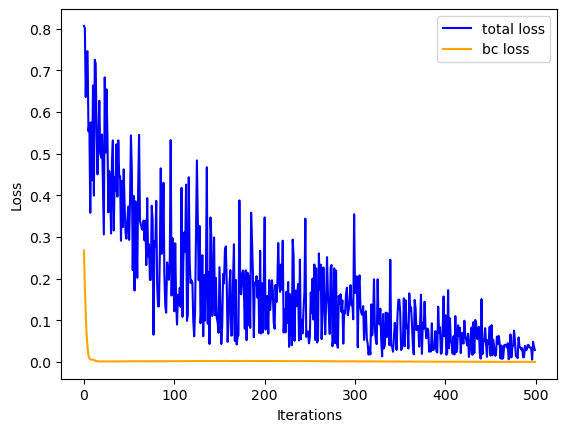

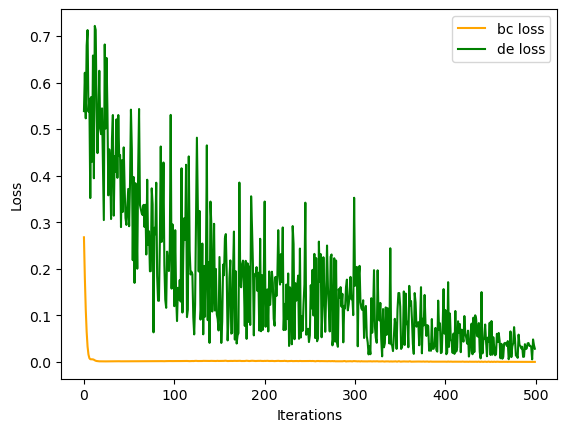

In [28]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

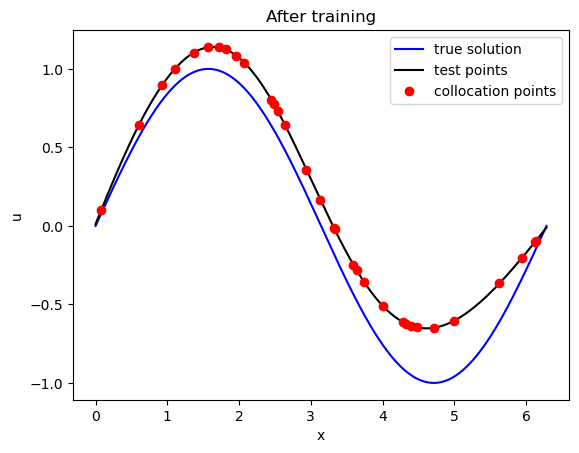

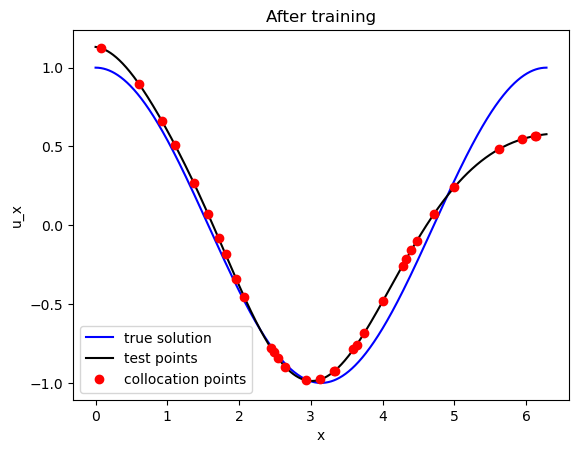

In [42]:
u = u_NN(x)
u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

# test points
xt = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
u_true = u_analytic(xt)
u_x_true = u_x_analytic(xt)

xt = torch.tensor(xt, dtype=torch.float, requires_grad=True).to(device)
u_test = u_NN(xt)
u_x_test = torch.autograd.grad(u_test, xt, torch.ones_like(u_test), create_graph=True)[0]

plt.figure(1)
plt.plot(xt.detach().cpu().numpy(), u_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u')
plt.title('After training')
plt.legend()

plt.figure(2)
plt.plot(xt.detach().cpu().numpy(), u_x_true, 'b-', label='true solution')
plt.plot(xt.detach().cpu().numpy(), u_x_test.detach().cpu().numpy(), 'k-', label='test points')
plt.plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), 'ro', label='collocation points')
plt.xlabel('x')
plt.ylabel('u_x')
plt.title('After training')
plt.legend()

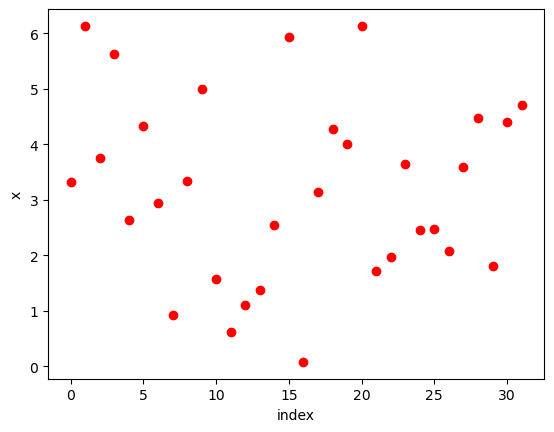

In [45]:
plt.figure(1)
plt.plot(x.detach().cpu().numpy(), 'ro')
plt.ylabel('x')
plt.xlabel('index')
plt.show()